In [15]:
from snf import datasets
import snf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import pickle as pk
from matplotlib import cm

In [10]:
# load data
dest_folder = '/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/NMF_output/'

df = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/rep1_spikein_curated.xls')
ribo = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/ribo_curated.xls')
ribo_hen = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/Hentschel_etal_ribo.xlsx')
raw_data = np.load('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/packed_rep1_spikein.npy')
gff = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/start_over_once_more/references/Msm_gff.xlsx')
GEMATRIA_NMF = np.load(dest_folder+'NMF_regrouped.npy')
h = np.load(dest_folder+'NMF_basis.npy')
w = np.load(dest_folder+'NMF_encoding.npy')

In [5]:
GEMATRIA_NMF_norm = GEMATRIA_NMF*np.mean(h,axis=1)[np.newaxis,np.newaxis,:]

In [4]:
# restructure an older version of GEMATRIA data to fit SNFpy package
snf_struct = []
for i in range(10):
    snf_struct.append(GEMATRIA_NMF[:,i,:])
# compute affinity 
affinity_networks = snf.make_affinity(snf_struct, metric='correlation', K=10, mu=0.5)
# SNF
fused_network = snf.snf(affinity_networks, K=10)
fused_network[np.diag_indices_from(fused_network)]=0

In [5]:
def LRFP_reader(folder,key,dataframe):
    import glob
    import tifffile
    for file in glob.glob(folder+'*.png'):
        if key in file:
            return plt.imread(file)
            break
        elif key in dataframe['locus'].values:
            k=dataframe[dataframe['locus']==key]['key'].values[0]
            print(k)
            file = folder+'LRFP_{}.png'.format(k)
            return plt.imread(file)
            break

def format_names(name_list):
    new_names = []
    for n in name_list:
        if n.startswith('MSMEG'):
            new_names.append(n.split('_')[1])
        else:
            new_names.append(n[0].capitalize()+n[1:])
    return new_names

def locate_strains(xpos,ypos, xmin, xmax, ymin, ymax):
    filtered = np.where((xpos<xmax)&(xpos>xmin)&(ypos<ymax)&(ypos>ymin))[0]
    return filtered

"""
for i in np.flip(np.argsort(fused_network[426]))[:10]:
    fig=plt.figure(figsize=(2,10))
    locus = df.iloc[i]['locus']
    print(locus)
    img = LRFP_reader('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/figures/LRFP/',locus,df)
    plt.imshow(img)
"""

"\nfor i in np.flip(np.argsort(fused_network[426]))[:10]:\n    fig=plt.figure(figsize=(2,10))\n    locus = df.iloc[i]['locus']\n    print(locus)\n    img = LRFP_reader('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/figures/LRFP/',locus,df)\n    plt.imshow(img)\n"

In [7]:
# cutoff set as 90 percentile
cutoff = np.percentile(fused_network,90)
g = nx.Graph()
indices = np.where(fused_network>=cutoff)
gdata = np.zeros((len(indices[0]),2))
gdata[:,0]=indices[0]
gdata[:,1]=indices[1]

# unweighted edges
#gdata[:,2]=fused_network[indices[0],indices[1]]
g.add_edges_from(gdata.astype(int))

# try different seeds
for x in range(0,50,2):
    pos = nx.layout.spring_layout(g,k=0.3,seed=x)
    fig=plt.figure(figsize=(8,8))
    positions = np.zeros((len(pos),2))
    for k,v in pos.items():
        positions[k]=v
    positions=positions.T
    #nodes = nx.draw_networkx_nodes(g,pos=pos,node_color=clusters.labels_[np.array(g.nodes)],
                               #alpha=0.8,node_size=120,weight='weight',cmap='Set3',lw=0.05)
    #nodes.set_edgecolor('black')
    ax = plt.subplot(111)
    subset1=ribo['Unnamed: 0'].values
    subset2=np.array([699,332,153,440,426])
    edges = nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.05)
    plt.scatter(positions[0],positions[1],s=30,
                c='c',
                ec='black',lw=0.1,alpha=0.8)
    plt.scatter(positions[0,subset1],positions[1,subset1],s=50,
                c='r',
                ec='black',lw=0.1,alpha=0.8)

    plt.scatter(positions[0,subset2],positions[1,subset2],s=50,
                c='orange',
                ec='black',lw=0.1,alpha=0.8)
    for i,s in enumerate(format_names(df.iloc[subset2]['name'].values)):
        _x=positions[0,subset2[i]]
        _y=positions[1,subset2[i]]
        plt.annotate(s,(_x,_y),fontname='Arial',fontsize=12,va='center',ha='center')
    #plt.xlim(-1,0,-0.5)
    #plt.ylim(-0.7,-0.4)
    #plt.axis('off')
    plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/figures/network_embedding/correlation_composite_network_{}.png'.format(x),
                dpi=160,bbox_inches='tight',transparent=True)
    plt.close()

In [6]:
# cutoff set as 90 percentile
cutoff = np.percentile(fused_network,90)
g = nx.Graph()
indices = np.where(fused_network>=cutoff)
gdata = np.zeros((len(indices[0]),2))
gdata[:,0]=indices[0]
gdata[:,1]=indices[1]

# settle with seed = 24
# unweighted edges
#gdata[:,2]=fused_network[indices[0],indices[1]]
g.add_edges_from(gdata.astype(int))

final_pos = nx.layout.spring_layout(g,k=0.3,seed=24)
positions = np.zeros((len(final_pos),2))
for k,v in final_pos.items():
    positions[k]=v
positions=positions.T
snf_data = {'network':g,'embedding':final_pos,'composite_graph':fused_network,'positions':positions}
#pk.dump(snf_data,open('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/SNF_output/SNF_output.pk','wb'))

(-1.0891540050506592,
 0.8722341060638428,
 -0.7374190121889115,
 0.9574601083993912)

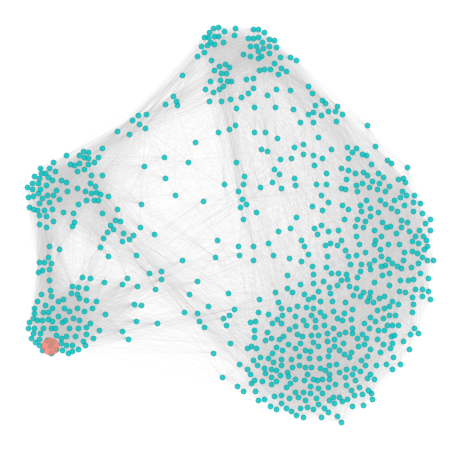

In [8]:
# network visualization without node label
fig=plt.figure(figsize=(8,8))
ax = plt.subplot(111)
edges = nx.draw_networkx_edges(g,
                               pos=final_pos,
                               edge_color='silver',
                               alpha=0.05,
                               width=0.8)

plt.scatter(positions[0,:],positions[1,:],s=30,
            c='c',
            ec='black',lw=0.1,alpha=0.8)

plt.scatter(positions[0,33],positions[1,33],s=300,
            c='salmon',
            ec='black',lw=0.1,alpha=0.8)

plt.axis('off')
#plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/composite_network.png',
#            dpi=160,bbox_inches='tight',transparent=True)

In [11]:
# restructure an older version of GEMATRIA data to fit SNFpy package
snf_struct = []
for i in range(10):
    snf_struct.append(GEMATRIA_NMF_norm[:,i,:])
# compute affinity 
affinity_networks = snf.make_affinity(snf_struct, metric='correlation', K=10, mu=0.5)
# SNF
fused_network = snf.snf(affinity_networks, K=10)
fused_network[np.diag_indices_from(fused_network)]=0

In [14]:
import xlsxwriter as xls
folder='/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/feature_thumbnails/'
gem_file = xls.Workbook('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/gem_file.xlsx')
for l in range(10):
    worksheet = gem_file.add_worksheet('length bin {}'.format(l+1))
    worksheet.set_row(0,45)
    worksheet.write('A1','MSR_index')
    worksheet.write_column('A2',df['key'])
    #worksheet.set_column('A:A',.format(c,c),10)
    for i,x in enumerate(['{}1'.format(j) for j in 'BCDEFGHIJKLMNOPQRSTU']):
        c=x[0]
        worksheet.set_column('{}:{}'.format(c,c),11)
        worksheet.insert_image(x,folder+'{}.png'.format(i+1),{'x_scale': 1.1, 'y_scale': 1.1})
        worksheet.write_column(c+'2',GEMATRIA_NMF[:,l,i])
gem_file.close()

In [13]:
import os

folder = '/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/feature_thumbnails/'
if not os.path.isdir(folder):
    os.mkdir(folder)
for i in range(20):
    fig=plt.figure(figsize=(1.5,0.75),tight_layout=True)
    plt.axis('off')
    plt.imshow(h[i].reshape(15,30),cmap='viridis')
    plt.title('Feature {}'.format(i+1),fontname='Arial',fontsize=7)
    plt.savefig(folder+'{}.png'.format(i+1),dpi=120,bbox_inches='tight')
    plt.close()

In [13]:
df

,New_index,Original_index,key,locus,name,image_count,experiment,replicate,SAFE_input
0,0,0,MSR_01_A01_MSMEG_0024,MSMEG_0024,ppiA,6,MSR,1,1
1,1,1,MSR_01_A02_MSMEG_0229,MSMEG_0229,ilvD,6,MSR,1,1
2,2,2,MSR_01_A03_MSMEG_0384,MSMEG_0384,rfbA,6,MSR,1,1
3,3,3,MSR_01_A04_MSMEG_0710,MSMEG_0710,grpE,6,MSR,1,1
4,4,4,MSR_01_A07_MSMEG_0225,MSMEG_0225,mmpL5,5,MSR,1,1
...,...,...,...,...,...,...,...,...,...
772,772,773,CB1163_TRITC,MSMEG_4222,ftsZ-4,0,Div,2,2
773,773,774,control_FITC,ctrl,mNeonGreen,0,FP_ctrl,1,2
774,774,775,control_TRITC,ctrl,mScarlet,0,FP_ctrl,1,2
775,775,776,FM464_TRITC,FM464,FM464,0,Chemi,1,2


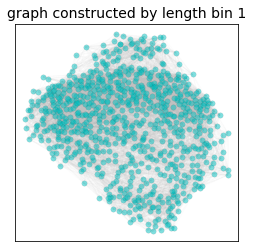

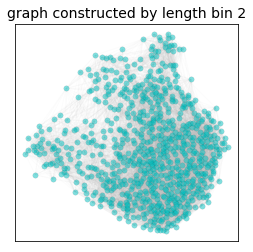

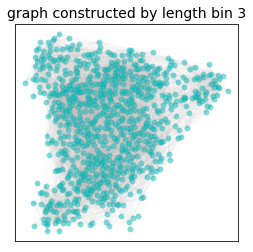

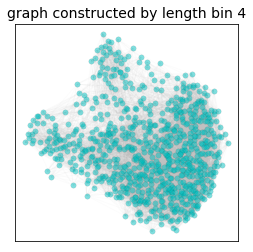

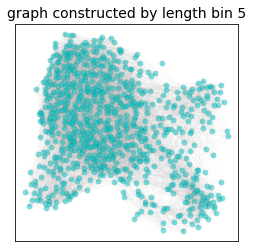

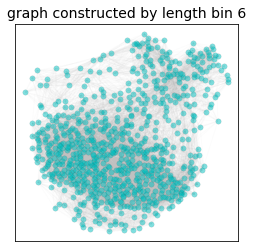

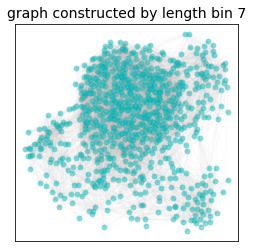

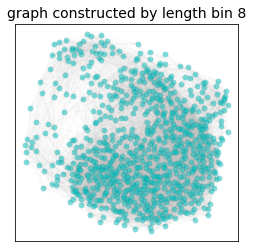

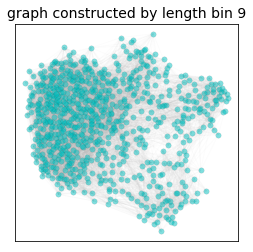

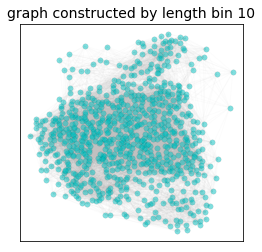

In [21]:
for t in range(10):
    cutoff = np.percentile(affinity_networks[t],95)
    g = nx.Graph()
    indices = np.where(affinity_networks[t]>=cutoff)
    gdata = np.zeros((len(indices[0]),2))
    gdata[:,0]=indices[0]
    gdata[:,1]=indices[1]

    # settle with seed = 24
    # unweighted edges
    #gdata[:,2]=fused_network[indices[0],indices[1]]
    g.add_edges_from(gdata.astype(int))

    final_pos = nx.layout.spring_layout(g,k=0.3,seed=24)
    positions = np.zeros((len(final_pos),2))
    for k,v in final_pos.items():
        positions[k]=v
    positions=positions.T
    snf_data = {'network':g,'embedding':final_pos,'composite_graph':fused_network,'positions':positions}

    fig=plt.figure(figsize=(4,4))
    ax = plt.subplot(111)
    edges = nx.draw_networkx_edges(g,
                               pos=final_pos,
                               edge_color='silver',
                               alpha=0.05,
                               width=0.8)

    plt.scatter(positions[0,:],positions[1,:],s=30,
                c='c',
                ec='black',lw=0.1,alpha=0.5)
    plt.title('graph constructed by length bin {}'.format(t+1), fontsize=14)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/correlation_matrices/graph_slice_{}'.format(t+1),bbox_inches='tight',dpi=120)

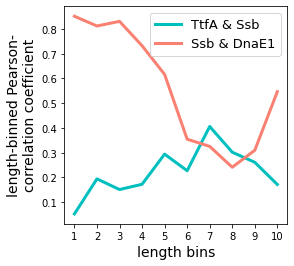

In [27]:
from scipy import stats
ttfA, ssb, mmpl3 = df.set_index('locus').loc[['MSMEG_0736','MSMEG_6895','MSMEG_3178']]['New_index'].values
v1 = GEMATRIA_NMF[ttfA]
v2 = GEMATRIA_NMF[ssb]
v3 = GEMATRIA_NMF[mmpl3]
ttfA_ssb = []
ttfA_mmpL3 = []
for i in range(10):
    ttfA_ssb.append(stats.pearsonr(v1[i],v2[i])[0])
    ttfA_mmpL3.append(stats.pearsonr(v2[i],v3[i])[0])
    
fig=plt.figure(figsize=(4,4))
plt.ylabel('length-binned Pearson-\ncorrelation coefficient',fontsize=14)
plt.xticks(np.arange(10),np.arange(10)+1)
plt.xlabel('length bins',fontsize=14)
plt.plot(ttfA_ssb,label='TtfA & Ssb',color='c',lw=3)
plt.plot(ttfA_mmpL3, label='Ssb & DnaE1',color='salmon',lw=3)
plt.legend(prop={'size':13})
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/correlation_matrices/temporal_correlation',bbox_inches='tight',dpi=120)

In [48]:
af = np.mean(affinity_networks,axis=0)
af[np.diag_indices_from(af)]=0
cutoff = np.percentile(af,95)
g = nx.Graph()
indices = np.where(affinity_networks[t]>=cutoff)
gdata = np.zeros((len(indices[0]),2))
gdata[:,0]=indices[0]
gdata[:,1]=indices[1]

    # settle with seed = 24
    # unweighted edges
    #gdata[:,2]=fused_network[indices[0],indices[1]]
g.add_edges_from(gdata.astype(int))

final_pos = nx.layout.spring_layout(g,k=0.3,seed=24)
positions = np.zeros((len(final_pos),2))
for k,v in final_pos.items():
    positions[k]=v
positions=positions.T

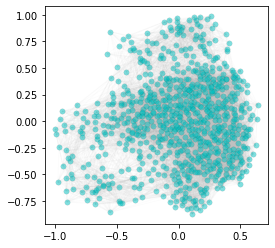

In [49]:
fig=plt.figure(figsize=(4,4))
ax = plt.subplot(111)
edges = nx.draw_networkx_edges(g,
                               pos=final_pos,
                               edge_color='silver',
                               alpha=0.05,
                               width=0.8)

plt.scatter(positions[0,:],positions[1,:],s=30,
                c='c',
                ec='black',lw=0.1,alpha=0.5)

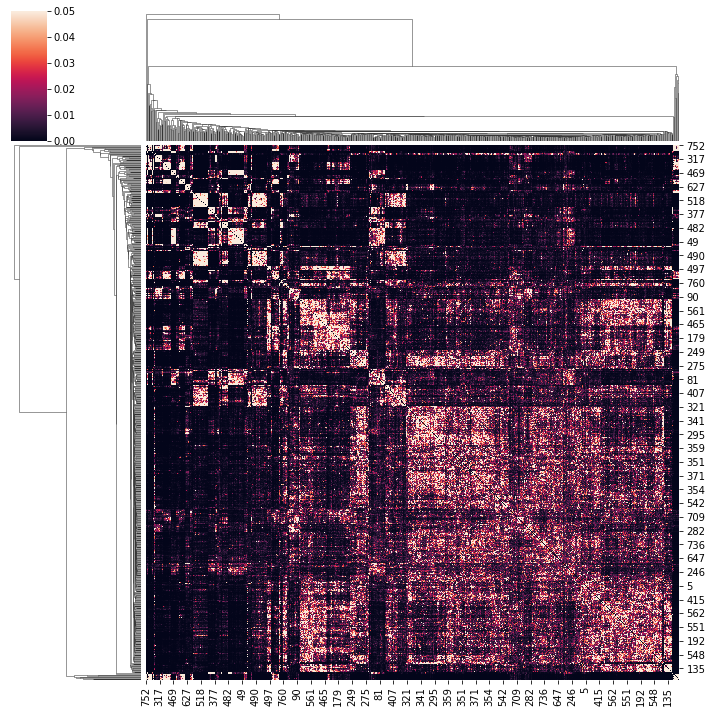

In [47]:
sns.clustermap(af,vmax=0.05)